In [1]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import shap 

In [2]:
df = pd.read_csv(r"C:\Users\chech\OneDrive\Documentos\StudyNights\test-rappi-DS\assets\house_sales.csv")
df.head()

,price,num_bed,num_bath,size_house,size_lot,num_floors,is_waterfront,condition,size_basement,year_built,renovation_date,zip,latitude,longitude,avg_size_neighbor_houses,avg_size_neighbor_lot
0,221900,3,1.00,1180,5650,1.0,0,3,0,1955,0,98178,47.511234,-122.256775,1340,5650
1,538000,3,2.25,2570,7242,2.0,0,3,400,1951,1991,98125,47.721023,-122.318862,1690,7639
2,180000,2,1.00,770,10000,1.0,0,3,0,1933,0,98028,47.737927,-122.233196,2720,8062
3,604000,4,3.00,1960,5000,1.0,0,5,910,1965,0,98136,47.520820,-122.393185,1360,5000
4,510000,3,2.00,1680,8080,1.0,0,3,0,1987,0,98074,47.616812,-122.044901,1800,7503


The links we are using are: 
https://github.com/slundberg/shap
https://shap-lrjball.readthedocs.io/en/latest/generated/shap.summary_plot.html
https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
https://wellsr.com/python/data-scaling-and-normalization-with-python/
https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663

So, lets first go ahead and separate our data between features, and the target. In this case, the target is Price

In [3]:
target = df.price
df_features = df.drop(['price', 'num_bath', 'size_house', 'avg_size_neighbor_houses'], axis =1)

Given that we are going to train with xgboost, we may either use the Matrix version or the sckit-learn API (https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663 for reference), where we need to calculate our metrics. We will be using RMSE. 

In [4]:
xtrain, xtest, ytrain, ytest = train_test_split(df_features, target, test_size=0.2)
xgbr = xgb.XGBRegressor(objective='reg:squarederror')
xgbr.fit(xtrain, ytrain)
 
ypred = xgbr.predict(xtest)
mse = mean_squared_error(ytest, ypred)
print("RMSE: %.2f" % (mse**(1/2.0)))

RMSE: 177012.39


So far so good, we haven't even told the xgb instace which values to the params we want to use. Let's maybe go ahead with a Hyperparameter Tuning, to see if maybe we can improve our RMSE metric. 

In [5]:
params = { 'max_depth': [3,6],
           'learning_rate': [0.01, 0.05],
           'n_estimators': [100, 500],
           'colsample_bytree': [0.3, 0.7]
           }
xgbr = xgb.XGBRegressor(seed = 20)
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

clf.fit(xtrain, ytrain)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  1.8min finished


Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 500}
Lowest RMSE:  158847.6004273378


Given that i am running out of time, i will use the other way of xgboost (with matrices) so i can put the optimized parameters into training the model. 

In [6]:
num_boost_round = 999

dtrain = xgb.DMatrix(xtrain, label=ytrain)
dtest = xgb.DMatrix(xtest, label=ytest)
model = xgb.train(
     clf.best_params_,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)
print("Best RMSE: {} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))


[20:34:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	Test-rmse:649509.56138
[1]	Test-rmse:624936.72583
[2]	Test-rmse:600825.82395
[3]	Test-rmse:577478.02359
[4]	Test-rmse:555665.51032
[5]	Test-rmse:534953.34984
[6]	Test-rmse:515544.07611
[7]	Test-rmse:497449.35344
[8]	Test-rmse:481107.71411
[9]	Test-rmse:466155.35485
[10]	Test-rmse:450782.14606
[11]	Test-rmse:435672.32978
[12]	Test-rmse:422922.17313
[13]	Test-rmse:410903.31477
[14]	Test-rmse:399617.70213
[15]	Test-rmse:387476.61785
[16]	Test-rmse:376651.88196
[17]	Test-rmse:367086.67492
[18]	Test-rmse:357970.82497
[19]	Test-rmse:348930.05677
[20]	Test-rmse:341181.37264
[

Now that we have our model tuned, let's check out which are the variables that have the most importance into getting our model trained to estimate the price houses for the given region.

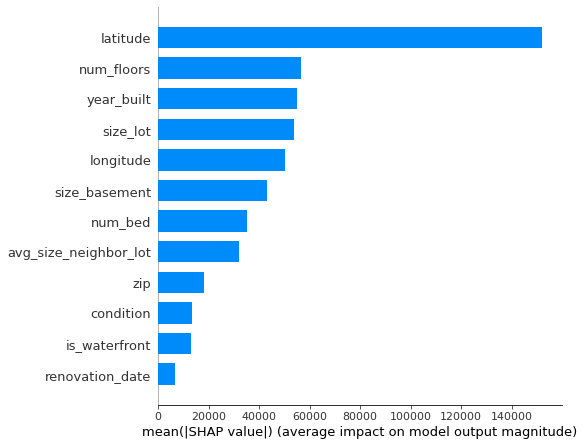

In [7]:

explainer = shap.Explainer(model)
shap_values = explainer(xtest)
shap.summary_plot(shap_values, xtest, plot_type="bar", feature_names = df_features.columns.to_list())